In [46]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import json
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import hvplot.pandas

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import alpaca_trade_api as tradeapi
import datetime
from dateutil.relativedelta import relativedelta

import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pickle

import p2_FMP_Requests as fmp

# Load the environment variables from the .env file
load_dotenv()

fmp_apikey = os.getenv("FMP_API_KEY")
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

## Initializations

In [47]:
filepath = './Resources/AMD_data.csv'
ticker = 'AMD'
num_periods = "1000"
short_window = 4
long_window = 20

___
## Get Data

In [48]:
# Get data from file
data = pd.read_csv(filepath, index_col='date', parse_dates=True, infer_datetime_format=True)
data

,open,high,low,close,volume,vwap
date,,,,,,
2018-10-11,24.740000,26.200001,24.549999,25.299999,147013800.0,25.35000
2018-10-12,26.770000,26.969999,25.670000,26.340000,111059400.0,26.32667
2018-10-15,26.379999,26.770000,25.750000,26.260000,70523500.0,26.26000
2018-10-16,26.629999,28.230000,26.170000,28.180000,92529000.0,27.52667
2018-10-17,28.410000,28.530001,26.920000,27.299999,89466900.0,27.58333
...,...,...,...,...,...,...
2022-09-26,67.870000,68.740000,66.250000,66.300000,81596933.0,67.09667
2022-09-27,67.900000,68.780000,66.000000,67.170000,94852032.0,67.31667
2022-09-28,67.110000,68.797900,66.560000,68.360000,72374412.0,67.90597


In [49]:
# ## Get live data from FinancialModellingPrep.com
# data_hist_price_response = fmp.get_historial_daily_stock_price_last_x_days(ticker, num_days, fmp_apikey)
# data_hist_price_df = pd.DataFrame(data_hist_price_response['historical']).drop('label', axis=1).set_index('date')

# data = data_hist_price_df.sort_index(ascending=True)
# data = data.drop(['unadjustedVolume', 'adjClose', 'change', 'changePercent', 'changeOverTime'], axis=1)

# data.to_csv(filepath)
# data

In [50]:
## Get live data from Alpaca Markets

# # Create the Alpaca tradeapi.REST object
# alpaca = tradeapi.REST(
#     alpaca_api_key,
#     alpaca_secret_key,
#     api_version = "v2"
# )

# # Set start and end dates
# today = datetime.datetime.today().date()
# back = today - relativedelta(years=10)
# print(today,back)

# start_date = pd.Timestamp(back, tz="America/New_York").isoformat()
# end_date = pd.Timestamp(today, tz="America/New_York").isoformat()
# print(start_date, end_date)

# closing_prices_df = alpaca.get_bars("NVDA", TimeFrame.Day, start_date, end_date, adjustment='raw').df

# data.to_csv(filepath)


___
## Use Technical Indicators to generate features

#### Feature - CCI (Commodity Channel Index)

In [52]:
periods = 20
TP = (data['high'] + data['low'] + data['close']) / 3
CCI = pd.Series((TP - TP.rolling(window=periods).mean()) / (0.015 * TP.rolling(window=periods).std()), name = 'CCI')
data = pd.concat([data, CCI], axis=1)

#### Feature - EVM (Ease of Movement)

In [53]:
periods = 14
dm = ((data['high'] + data['low'])/2) - ((data['high'].shift(1) + data['low'].shift(1))/2)
br = (data['volume'] / 100000000) / ((data['high'] - data['low']))
EVM = dm / br 
EVM_MA = pd.Series(EVM.rolling(window=periods).mean(), name = 'EVM')
data = pd.concat([data, EVM_MA], axis=1)


#### Features - SMA (Simple Moving Average) & EWMA (Exponentially Weighted Moving Average)

In [54]:
def SMA(data, periods): 
    close = data['close']
    sma = pd.Series(close.rolling(window=periods).mean(), name = ('SMA_' + str(periods)))
    data = pd.concat([data, sma], axis=1)
    return data

In [55]:
def EWMA(data, periods):
    close = data['close']
    ema = pd.Series(close.ewm(span = periods, min_periods = (periods - 1)).mean(), name = 'EWMA_' + str(periods))
    data = pd.concat([data, ema], axis=1)
    return data

In [56]:
# Calculate SMAs
periods_list = [short_window,long_window,100,200]
for periods in periods_list:
    data = SMA(data, periods)
    data = EWMA(data, periods)


#### Feature - ROC (price Rate Of Change)

In [57]:
periods = 5
N = data['close'].diff(periods)
D = data['close'].shift(periods)
roc = pd.Series(N/D,name='ROC')
data = pd.concat([data, roc], axis=1)


#### Feature - Bolinger Bands

In [58]:
periods = 50
MA = data.close.rolling(window=periods).mean()
SD = data.close.rolling(window=periods).std()
data['UpperBB'] = MA + (2 * SD) 
data['LowerBB'] = MA - (2 * SD)


#### Feature - Force Index

In [59]:
periods = 1
FI = pd.Series(data['close'].diff(periods) * data['volume'], name = 'ForceIndex') 
data = data = pd.concat([data, FI], axis=1)


In [60]:
data = data.dropna().astype('float')
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-07-30,33.209999,33.939999,32.939999,33.869999,72198900.0,33.58333,35.594743,-0.048567,33.759999,33.739032,33.1010,32.942798,28.8484,29.286981,25.07465,27.412309,0.011347,35.689469,26.266531,2.815750e+07
2019-07-31,32.080002,32.299999,30.299999,30.450001,119190000.0,31.01667,-129.556965,-0.260831,32.955000,32.423419,33.0615,32.705389,28.9328,29.310432,25.10040,27.447211,-0.107300,35.601972,26.504828,-4.076296e+08
2019-08-01,30.500000,31.480000,29.100000,29.860001,80878900.0,30.14667,-165.216298,-0.429859,31.915000,31.398052,32.9950,32.434400,29.0018,29.321509,25.11800,27.474891,-0.113157,35.539350,26.667850,-4.771855e+07
2019-08-02,29.480000,29.730000,28.940001,29.440001,60410900.0,29.37000,-173.230505,-0.647354,30.905000,30.614832,32.8920,32.149219,29.0613,29.323897,25.13390,27.497400,-0.134627,35.477950,26.810451,-2.537258e+07
2019-08-05,28.260000,28.490000,27.650000,27.990000,74333200.0,28.04333,-180.097992,-0.796987,29.435001,29.564899,32.6895,31.753103,29.1074,29.297029,25.13295,27.503034,-0.163978,35.386403,26.967198,-1.077832e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,67.870000,68.740000,66.250000,66.300000,81596933.0,67.09667,-131.003463,-3.992160,69.560000,69.185701,78.5990,78.177987,88.9299,89.891438,103.37620,96.389171,-0.136381,107.978621,68.538979,-1.354509e+08
2022-09-27,67.900000,68.780000,66.000000,67.170000,94852032.0,67.31667,-116.469404,-3.846118,67.732500,68.379421,77.5330,77.129608,88.6074,89.441509,103.02155,96.098419,-0.107375,108.492803,67.454397,8.252127e+07
2022-09-28,67.110000,68.797900,66.560000,68.360000,72374412.0,67.90597,-100.293937,-4.577983,67.447500,68.371652,76.6040,76.294407,88.3523,89.024053,102.67060,95.822402,-0.082170,108.873666,66.372734,8.612555e+07


___
## Generate Trading Signals using short and long SMA. Calculate P&L and ROI.

In [61]:
# Create a column to hold the trading signal
data['Signal'] = 0.0

In [62]:
# Generate the trading signal 0 or 1,
# where 1 is the short-window greater than the long-window
# and 0 is when the condition is not met

SMA_short = ('SMA_' + str(short_window))
SMA_long = ('SMA_' + str(long_window))

data['Signal'][short_window:] = np.where(
    data[SMA_short][short_window:] > data[SMA_long][short_window:], 1.0, 0.0
)

data.tail(10)

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal
date,,,,,,,,,,,,,,,,,,,,,
2022-09-19,75.390,77.3400,75.3500,76.77,64951777.0,76.48667,-79.229096,-5.071079,76.8475,77.305417,...,83.350451,89.8054,91.920365,105.22795,97.708965,-0.092982,106.285403,71.714197,1.688746e+07,0.0
2022-09-20,76.080,76.5800,74.7312,75.25,51035769.0,75.52040,-80.963796,-4.264652,76.2975,76.483250,...,82.578980,89.7088,91.590259,104.85080,97.485482,-0.023108,106.354524,71.577076,-7.757437e+07,0.0
2022-09-21,75.435,78.4100,74.4500,74.48,82037876.0,75.78000,-71.651882,-3.164485,75.7525,75.681950,...,81.807648,89.5572,91.251442,104.50315,97.256560,-0.038347,106.435903,71.420497,-6.316916e+07,0.0
2022-09-22,73.890,74.2900,69.1700,69.50,101405425.0,70.98667,-109.724809,-3.393320,74.0000,73.209170,...,80.635491,89.3970,90.820720,104.15535,96.980362,-0.093399,106.839963,70.695637,-5.049990e+08,0.0
2022-09-23,68.000,69.0801,66.8216,67.96,87653233.0,67.95390,-132.318170,-4.442370,71.7975,71.109502,...,79.428302,89.1782,90.368033,103.77090,96.691589,-0.111750,107.351881,69.758119,-1.349860e+08,0.0
2022-09-26,67.870,68.7400,66.2500,66.30,81596933.0,67.09667,-131.003463,-3.992160,69.5600,69.185701,...,78.177987,88.9299,89.891438,103.37620,96.389171,-0.136381,107.978621,68.538979,-1.354509e+08,0.0
2022-09-27,67.900,68.7800,66.0000,67.17,94852032.0,67.31667,-116.469404,-3.846118,67.7325,68.379421,...,77.129608,88.6074,89.441509,103.02155,96.098419,-0.107375,108.492803,67.454397,8.252127e+07,0.0
2022-09-28,67.110,68.7979,66.5600,68.36,72374412.0,67.90597,-100.293937,-4.577983,67.4475,68.371652,...,76.294407,88.3523,89.024053,102.67060,95.822402,-0.082170,108.873666,66.372734,8.612555e+07,0.0
2022-09-29,67.150,67.2000,62.8301,64.14,100821467.0,64.72337,-120.115644,-6.054715,66.4925,66.678991,...,75.136844,88.0403,88.531299,102.32230,95.507140,-0.077122,109.372484,64.862316,-4.254666e+08,0.0


In [63]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
data['Entry/Exit'] = data['Signal'].diff()
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit
date,,,,,,,,,,,,,,,,,,,,,
2019-07-30,33.209999,33.939999,32.939999,33.869999,72198900.0,33.58333,35.594743,-0.048567,33.759999,33.739032,...,28.8484,29.286981,25.07465,27.412309,0.011347,35.689469,26.266531,2.815750e+07,0.0,NaN
2019-07-31,32.080002,32.299999,30.299999,30.450001,119190000.0,31.01667,-129.556965,-0.260831,32.955000,32.423419,...,28.9328,29.310432,25.10040,27.447211,-0.107300,35.601972,26.504828,-4.076296e+08,0.0,0.0
2019-08-01,30.500000,31.480000,29.100000,29.860001,80878900.0,30.14667,-165.216298,-0.429859,31.915000,31.398052,...,29.0018,29.321509,25.11800,27.474891,-0.113157,35.539350,26.667850,-4.771855e+07,0.0,0.0
2019-08-02,29.480000,29.730000,28.940001,29.440001,60410900.0,29.37000,-173.230505,-0.647354,30.905000,30.614832,...,29.0613,29.323897,25.13390,27.497400,-0.134627,35.477950,26.810451,-2.537258e+07,0.0,0.0
2019-08-05,28.260000,28.490000,27.650000,27.990000,74333200.0,28.04333,-180.097992,-0.796987,29.435001,29.564899,...,29.1074,29.297029,25.13295,27.503034,-0.163978,35.386403,26.967198,-1.077832e+08,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,67.870000,68.740000,66.250000,66.300000,81596933.0,67.09667,-131.003463,-3.992160,69.560000,69.185701,...,88.9299,89.891438,103.37620,96.389171,-0.136381,107.978621,68.538979,-1.354509e+08,0.0,0.0
2022-09-27,67.900000,68.780000,66.000000,67.170000,94852032.0,67.31667,-116.469404,-3.846118,67.732500,68.379421,...,88.6074,89.441509,103.02155,96.098419,-0.107375,108.492803,67.454397,8.252127e+07,0.0,0.0
2022-09-28,67.110000,68.797900,66.560000,68.360000,72374412.0,67.90597,-100.293937,-4.577983,67.447500,68.371652,...,88.3523,89.024053,102.67060,95.822402,-0.082170,108.873666,66.372734,8.612555e+07,0.0,0.0


In [64]:
data['Entry/Exit'].value_counts()

 0.0    746
 1.0     27
-1.0     27
Name: Entry/Exit, dtype: int64

In [65]:
# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


In [66]:
# Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


In [67]:
# Visualize close price for the investment
security_close = data[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)


In [68]:
# Visualize moving averages
moving_avgs = data[[SMA_short, SMA_long]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)


In [69]:
# Create the overlay plot
entry_exit_plot = moving_avgs * security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': SMA_short, SMA_long, Entry and Exit Points')
)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I          :Curve   [date]   (close)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

#### Execute trades based on the entry/exit signals and calculate P&L

In [70]:
# Add the trade_type column to track buys and sells
data['trade_type'] = np.nan

In [71]:
# Initialize a cost/proceeds column for recording trade metrics
data["cost/proceeds"] = np.nan

In [72]:
# Initialize share size and accumulated shares
share_size = 100
accumulated_shares = 0
bought = False
initial_investment = 0

In [73]:
# Loop through the Pandas DataFrame and initiate a trade at each iteration
for index, row in data.iterrows():

    # buy if the previous_price is 0, in other words, buy on the first day
    if row["Entry/Exit"] == 1:
        data.loc[index, "trade_type"] = "buy"

        bought = True  # indicate stock has been bought

        if initial_investment == 0:
            initial_investment = row["close"] * share_size

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size

    # buy if the current day's price is less than the previous day's price
    elif row["Entry/Exit"] == -1 and bought: #able to sell only when stock has first been bought
        data.loc[index, "trade_type"] = "sell"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = (row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares -= share_size

    # hold if the current day's price is equal to the previous day's price
    else:
        data.loc[index, "trade_type"] = "hold"

    # if the index is the last index of the DataFrame and there is still accumulated stock, sell the remaining holding
    if index == data.index[-1] and accumulated_shares !=0:
        data.loc[index, "trade_type"] = "sell"

        # calculate the proceeds by multiplying the last day's price by the accumulated shares
        data.loc[index, "cost/proceeds"] = row["close"] * accumulated_shares

        accumulated_shares = 0

In [74]:
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit,trade_type,cost/proceeds
date,,,,,,,,,,,,,,,,,,,,,
2019-07-30,33.209999,33.939999,32.939999,33.869999,72198900.0,33.58333,35.594743,-0.048567,33.759999,33.739032,...,25.07465,27.412309,0.011347,35.689469,26.266531,2.815750e+07,0.0,NaN,hold,NaN
2019-07-31,32.080002,32.299999,30.299999,30.450001,119190000.0,31.01667,-129.556965,-0.260831,32.955000,32.423419,...,25.10040,27.447211,-0.107300,35.601972,26.504828,-4.076296e+08,0.0,0.0,hold,NaN
2019-08-01,30.500000,31.480000,29.100000,29.860001,80878900.0,30.14667,-165.216298,-0.429859,31.915000,31.398052,...,25.11800,27.474891,-0.113157,35.539350,26.667850,-4.771855e+07,0.0,0.0,hold,NaN
2019-08-02,29.480000,29.730000,28.940001,29.440001,60410900.0,29.37000,-173.230505,-0.647354,30.905000,30.614832,...,25.13390,27.497400,-0.134627,35.477950,26.810451,-2.537258e+07,0.0,0.0,hold,NaN
2019-08-05,28.260000,28.490000,27.650000,27.990000,74333200.0,28.04333,-180.097992,-0.796987,29.435001,29.564899,...,25.13295,27.503034,-0.163978,35.386403,26.967198,-1.077832e+08,0.0,0.0,hold,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,67.870000,68.740000,66.250000,66.300000,81596933.0,67.09667,-131.003463,-3.992160,69.560000,69.185701,...,103.37620,96.389171,-0.136381,107.978621,68.538979,-1.354509e+08,0.0,0.0,hold,NaN
2022-09-27,67.900000,68.780000,66.000000,67.170000,94852032.0,67.31667,-116.469404,-3.846118,67.732500,68.379421,...,103.02155,96.098419,-0.107375,108.492803,67.454397,8.252127e+07,0.0,0.0,hold,NaN
2022-09-28,67.110000,68.797900,66.560000,68.360000,72374412.0,67.90597,-100.293937,-4.577983,67.447500,68.371652,...,102.67060,95.822402,-0.082170,108.873666,66.372734,8.612555e+07,0.0,0.0,hold,NaN


In [75]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("accumulated_shares =", accumulated_shares)

accumulated_shares = 0


In [76]:
print (f"The investment made is ${initial_investment:,.2f}" )

The investment made is $3,243.00


In [77]:
# Calculate the total profit/loss for 100 share size orders
total_profit_loss = data["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

The total profit/loss of the trading strategy is $2,652.00


In [78]:
# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

The trading algorithm resulted in a return on investment of 81.78%


In [79]:
# # store file for checking trades using Excel
# filepath = Path(./Resources/'data.csv')   
# data.to_csv(filepath)

---
## Machine Learning

In [80]:
data_ml = data.shift().drop(columns=['Entry/Exit', 'trade_type', 'cost/proceeds']).dropna()
X = data_ml.drop(columns=['Signal'])
X

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-07-31,33.209999,33.939999,32.939999,33.869999,72198900.0,33.58333,35.594743,-0.048567,33.759999,33.739032,33.1010,32.942798,28.8484,29.286981,25.07465,27.412309,0.011347,35.689469,26.266531,2.815750e+07
2019-08-01,32.080002,32.299999,30.299999,30.450001,119190000.0,31.01667,-129.556965,-0.260831,32.955000,32.423419,33.0615,32.705389,28.9328,29.310432,25.10040,27.447211,-0.107300,35.601972,26.504828,-4.076296e+08
2019-08-02,30.500000,31.480000,29.100000,29.860001,80878900.0,30.14667,-165.216298,-0.429859,31.915000,31.398052,32.9950,32.434400,29.0018,29.321509,25.11800,27.474891,-0.113157,35.539350,26.667850,-4.771855e+07
2019-08-05,29.480000,29.730000,28.940001,29.440001,60410900.0,29.37000,-173.230505,-0.647354,30.905000,30.614832,32.8920,32.149219,29.0613,29.323897,25.13390,27.497400,-0.134627,35.477950,26.810451,-2.537258e+07
2019-08-06,28.260000,28.490000,27.650000,27.990000,74333200.0,28.04333,-180.097992,-0.796987,29.435001,29.564899,32.6895,31.753103,29.1074,29.297029,25.13295,27.503034,-0.163978,35.386403,26.967198,-1.077832e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,68.000000,69.080100,66.821600,67.960000,87653233.0,67.95390,-132.318170,-4.442370,71.797500,71.109502,79.8430,79.428302,89.1782,90.368033,103.77090,96.691589,-0.111750,107.351881,69.758119,-1.349860e+08
2022-09-27,67.870000,68.740000,66.250000,66.300000,81596933.0,67.09667,-131.003463,-3.992160,69.560000,69.185701,78.5990,78.177987,88.9299,89.891438,103.37620,96.389171,-0.136381,107.978621,68.538979,-1.354509e+08
2022-09-28,67.900000,68.780000,66.000000,67.170000,94852032.0,67.31667,-116.469404,-3.846118,67.732500,68.379421,77.5330,77.129608,88.6074,89.441509,103.02155,96.098419,-0.107375,108.492803,67.454397,8.252127e+07


In [81]:
# Review the value counts
y = data_ml['Signal']
y.value_counts()

1.0    433
0.0    367
Name: Signal, dtype: int64

In [82]:
y

date
2019-07-31    0.0
2019-08-01    0.0
2019-08-02    0.0
2019-08-05    0.0
2019-08-06    0.0
             ... 
2022-09-26    0.0
2022-09-27    0.0
2022-09-28    0.0
2022-09-29    0.0
2022-09-30    0.0
Name: Signal, Length: 800, dtype: float64

In [83]:
# Split train - test data
split_ratio=0.8
train_size = int(round(split_ratio * X.shape[0]))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 20) (640,)
(160, 20) (160,)


In [84]:
# Review the X_train DataFrame
X_train

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-07-31,33.209999,33.939999,32.939999,33.869999,72198900.0,33.58333,35.594743,-0.048567,33.759999,33.739032,33.1010,32.942798,28.8484,29.286981,25.07465,27.412309,0.011347,35.689469,26.266531,2.815750e+07
2019-08-01,32.080002,32.299999,30.299999,30.450001,119190000.0,31.01667,-129.556965,-0.260831,32.955000,32.423419,33.0615,32.705389,28.9328,29.310432,25.10040,27.447211,-0.107300,35.601972,26.504828,-4.076296e+08
2019-08-02,30.500000,31.480000,29.100000,29.860001,80878900.0,30.14667,-165.216298,-0.429859,31.915000,31.398052,32.9950,32.434400,29.0018,29.321509,25.11800,27.474891,-0.113157,35.539350,26.667850,-4.771855e+07
2019-08-05,29.480000,29.730000,28.940001,29.440001,60410900.0,29.37000,-173.230505,-0.647354,30.905000,30.614832,32.8920,32.149219,29.0613,29.323897,25.13390,27.497400,-0.134627,35.477950,26.810451,-2.537258e+07
2019-08-06,28.260000,28.490000,27.650000,27.990000,74333200.0,28.04333,-180.097992,-0.796987,29.435001,29.564899,32.6895,31.753103,29.1074,29.297029,25.13295,27.503034,-0.163978,35.386403,26.967198,-1.077832e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,120.320000,125.370000,118.816000,120.080000,101923676.0,121.42200,-12.845542,-10.989935,118.467500,118.174270,123.2805,122.579756,128.5438,126.385303,109.98105,115.155464,0.170370,165.223209,108.217191,-2.731555e+08
2022-02-07,120.340000,124.960000,118.580000,123.600000,85990482.0,122.38000,-3.331105,-9.853688,120.805000,120.344562,122.6490,122.676923,128.7225,126.330148,110.20375,115.239509,0.174458,164.673959,107.713641,3.026865e+08
2022-02-08,123.560000,127.630000,122.785000,123.670000,81680023.0,124.69500,14.082840,-8.260738,122.527500,121.674737,122.2325,122.771501,128.9032,126.277472,110.40830,115.323414,0.082451,163.509646,107.512754,5.717602e+06


In [85]:
# Review the X_test DataFrame
X_test

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2022-02-11,128.84,131.7589,124.6100,125.77,108942191.0,127.37963,41.004685,-0.197255,127.6300,126.938863,121.2360,124.351067,129.6552,126.432143,111.06935,115.725990,0.047385,159.317959,108.174841,-7.713107e+08
2022-02-14,126.14,127.1699,111.8100,113.18,164737585.0,117.38663,-24.183801,-0.539397,125.0075,121.435318,120.2580,123.287155,129.7588,126.169724,111.21570,115.700651,-0.084304,158.855248,107.200352,-2.074046e+09
2022-02-15,115.51,118.3700,113.4600,114.27,135150320.0,115.36667,-34.187601,-1.553970,121.5175,118.569191,119.1275,122.428379,129.8577,125.934086,111.37895,115.686413,-0.076009,158.148755,106.450445,1.473138e+08
2022-02-16,117.19,121.8800,114.3600,121.47,144152923.0,119.23667,2.474096,-1.090768,118.6725,119.729514,118.6045,122.337105,130.0109,125.845688,111.59355,115.743973,-0.052718,157.650518,106.047082,1.037901e+09
2022-02-17,119.05,119.5400,114.2200,117.69,119117961.0,117.15000,-10.518648,1.929976,116.6525,118.913709,118.0755,121.894523,130.1298,125.684189,111.78895,115.763341,-0.114114,157.442605,105.400195,-4.502659e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,68.00,69.0801,66.8216,67.96,87653233.0,67.95390,-132.318170,-4.442370,71.7975,71.109502,79.8430,79.428302,89.1782,90.368033,103.77090,96.691589,-0.111750,107.351881,69.758119,-1.349860e+08
2022-09-27,67.87,68.7400,66.2500,66.30,81596933.0,67.09667,-131.003463,-3.992160,69.5600,69.185701,78.5990,78.177987,88.9299,89.891438,103.37620,96.389171,-0.136381,107.978621,68.538979,-1.354509e+08
2022-09-28,67.90,68.7800,66.0000,67.17,94852032.0,67.31667,-116.469404,-3.846118,67.7325,68.379421,77.5330,77.129608,88.6074,89.441509,103.02155,96.098419,-0.107375,108.492803,67.454397,8.252127e+07


In [86]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Use the 'XGBoost' classifier model to fit the training data and make predictions based on the testing data.

In [87]:
# Instantiate XGB classifier model instance
model = xgb.XGBClassifier()
 
# Fit the model to the data using the training data
model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0])

In [88]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Print the classification report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        99
         1.0       0.89      0.92      0.90        61

    accuracy                           0.93       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.93      0.93      0.93       160



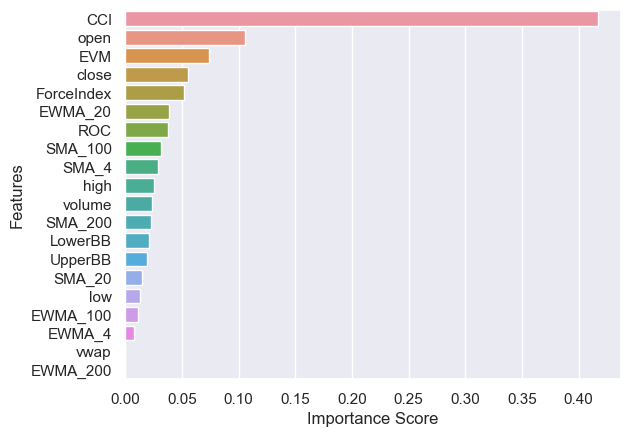

In [89]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

In [90]:
pickle.dump(model, open('./Resources/AMD_ml_model.pkl', 'wb'))